<a id='Header1'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">IMPORTS: PACKAGES USED</h1><a id='ExecSum'></a><a id='Title'></a><a

In [1]:
!pip install mglearn
!pip install skforecast

import warnings
from IPython.display import Image

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from statsmodels.tsa.stattools import adfuller

from sklearn.neighbors import KNeighborsClassifier
import mglearn #library provided by amueller
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

import time 

# from google.colab import drive
# drive.mount('/content/drive')
# dir = '/content/drive/MyDrive/ML1/'
dir = ''
data_dir = dir + 'avocado.csv'

<a id='Header2'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">FUNCTIONS</h1><a id='ExecSum'></a><a id='Title'></a><a

In [2]:
def get_traintest_scaled(X_train, X_test):
    features = X_train.columns
    sscaler = MinMaxScaler()
    sscaler.fit(X_train)
    X_Train = sscaler.transform(X_train.astype(float))
    X_Test = sscaler.transform(X_test.astype(float))
    X_train = pd.DataFrame(data = X_Train,columns = features) # Return the column names
    X_test = pd.DataFrame(data = X_Test,columns = features) # Return the column names
    return X_train, X_test
    
def forecaster_linearreg(X, y):
  start_time = time.time()
  delay = 5
  init_size = int(len(y)/2+1)

  clf = LinearRegression()
  forecaster = ForecasterAutoreg(
      regressor=clf,
      lags=5
  )

  predictions = pd.Series()
  for i in range(init_size, len(y)+1):
    X_train, X_test = get_traintest_scaled(X.iloc[0:i-delay,:],
                                          X.iloc[i-delay:i,:])
    y_train = y.iloc[0:i-delay,0]
    forecaster.fit(y=y_train, exog=X.iloc[0:i-delay,:])
    pred = forecaster.predict(steps=delay, exog=X.iloc[i-delay:i,:])
    predictions = pd.concat([predictions, pred[-1:]], axis=0)
  actuals = y.loc[predictions.index,'AveragePrice']
  mse = mean_squared_error(actuals, predictions)

  coefs = forecaster.get_feature_importances()
  top_predictor = coefs.loc[np.argsort(-np.abs(coefs.importance))].iloc[0,0]
  best_predictions = predictions
  top_score = mse
  run_time = (time.time() - start_time)
  row = ['Linear Regression', top_score, 'N/A', top_predictor, run_time]

  return row, best_predictions, coefs

def forecaster_ridge(X, y):
  start_time = time.time()
  delay = 5
  init_size = int(len(y)/2+1)

  alpha_range = np.logspace(-5, 5, 6)

  top_score = 10000
  for alpha_run in alpha_range:
      clf = Ridge(alpha=alpha_run)
      forecaster = ForecasterAutoreg(
          regressor=clf,
          lags=5
      )

      predictions = pd.Series()
      for i in range(init_size, len(y)+1):
        X_train, X_test = get_traintest_scaled(X.iloc[0:i-delay,:],
                                              X.iloc[i-delay:i,:])
        y_train = y.iloc[0:i-delay,0]
        forecaster.fit(y=y_train, exog=X.iloc[0:i-delay,:])
        pred = forecaster.predict(steps=delay, exog=X.iloc[i-delay:i,:])
        predictions = pd.concat([predictions, pred[-1:]], axis=0)
      actuals = y.loc[predictions.index,'AveragePrice']
      mse = mean_squared_error(actuals, predictions)

      if mse < top_score:
        coefs = forecaster.get_feature_importances()
        top_predictor = coefs.loc[np.argsort(-np.abs(coefs.importance))].iloc[0,0]
        best_predictions = predictions
        param = f'alpha = {alpha_run}'
        top_score = mse
  run_time = (time.time() - start_time)
  row = ['Ridge', top_score, param, top_predictor, run_time]

  return row, best_predictions, coefs

def forecaster_lasso(X, y):
  start_time = time.time()
  delay = 5
  init_size = int(len(y)/2+1)

  alpha_range = np.logspace(-5, 5, 6)

  top_score = 10000
  for alpha_run in alpha_range:
      clf = Lasso(alpha=alpha_run)
      forecaster = ForecasterAutoreg(
          regressor=clf,
          lags=5
      )

      predictions = pd.Series()
      for i in range(init_size, len(y)+1):
        X_train, X_test = get_traintest_scaled(X.iloc[0:i-delay,:],
                                              X.iloc[i-delay:i,:])
        y_train = y.iloc[0:i-delay,0]
        forecaster.fit(y=y_train, exog=X.iloc[0:i-delay,:])
        pred = forecaster.predict(steps=delay, exog=X.iloc[i-delay:i,:])
        predictions = pd.concat([predictions, pred[-1:]], axis=0)
      actuals = y.loc[predictions.index,'AveragePrice']
      mse = mean_squared_error(actuals, predictions)

      if mse < top_score:
        coefs = forecaster.get_feature_importances()
        top_predictor = coefs.loc[np.argsort(-np.abs(coefs.importance))].iloc[0,0]
        best_predictions = predictions
        param = f'alpha = {alpha_run}'
        top_score = mse
  run_time = (time.time() - start_time)
  row = ['Lasso', top_score, param, top_predictor, run_time]

  return row, best_predictions, coefs

def forecaster_SVR(X, y):
  start_time = time.time()
  delay = 5
  init_size = int(len(y)/2+1)

  C_range = np.logspace(-5, 5, 6)

  top_score = 10000
  for C_run in C_range:
      clf = SVR(C=C_run)
      forecaster = ForecasterAutoreg(
          regressor=clf,
          lags=5)

      predictions = pd.Series()
      for i in range(init_size, len(y)+1):
        X_train, X_test = get_traintest_scaled(X.iloc[0:i-delay,:],
                                              X.iloc[i-delay:i,:])
        y_train = y.iloc[0:i-delay,0]
        forecaster.fit(y=y_train, exog=X.iloc[0:i-delay,:])
        pred = forecaster.predict(steps=delay, exog=X.iloc[i-delay:i,:])
        predictions = pd.concat([predictions, pred[-1:]], axis=0)
      actuals = y.loc[predictions.index,'AveragePrice']
      mse = mean_squared_error(actuals, predictions)

      if mse < top_score:
        #coefs = forecaster.get_feature_importances()
        #coefs = clf.coef_
        #top_predictor = coefs.loc[np.argsort(-np.abs(coefs.importance))].iloc[0,0]
        best_predictions = predictions
        param = f'C={C_run}'
        top_score = mse
  run_time = (time.time() - start_time)
  row = ['SVR', top_score, param, 'N/A', run_time]

  return row, best_predictions, None

def forecaster_RF(X, y):
  start_time = time.time()
  delay = 5
  init_size = int(len(y)/2+1)

  max_depth_range = [3,4,5]
  max_features_tuning=[0.1, .2, .3, .4, .5, .7, .8]

  top_score = 10000
  for max_features_run in max_features_tuning:
    for max_depth_run in max_depth_range:
        clf = RandomForestRegressor(max_depth=max_depth_run, max_features=max_features_run)
        forecaster = ForecasterAutoreg(
            regressor=clf,
            lags=5
        )

        predictions = pd.Series()
        for i in range(init_size, len(y)+1):
          X_train, X_test = get_traintest_scaled(X.iloc[0:i-delay,:],
                                                X.iloc[i-delay:i,:])
          y_train = y.iloc[0:i-delay,0]
          forecaster.fit(y=y_train, exog=X.iloc[0:i-delay,:])
          pred = forecaster.predict(steps=delay, exog=X.iloc[i-delay:i,:])
          predictions = pd.concat([predictions, pred[-1:]], axis=0)
        actuals = y.loc[predictions.index,'AveragePrice']
        mse = mean_squared_error(actuals, predictions)

        if mse < top_score:
          coefs = forecaster.get_feature_importances()
          top_predictor = coefs.loc[np.argsort(-np.abs(coefs.importance))].iloc[0,0]
          best_predictions = predictions
          param = f'Max Depth={max_depth_run}, Max Features={max_features_run}'
          top_score = mse

  run_time = (time.time() - start_time)
  row = ['Random Forest', top_score, param, top_predictor, run_time]

  return row, best_predictions, coefs

def forecaster_GBM(X, y):
  start_time = time.time()
  delay = 5
  init_size = int(len(y)/2+1)

  learning_rate_range = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4]
  max_depth_range = [3,4,5]
  max_features_tuning=[0.1, .2, .3, .4, .5, .7, .8, 1]
  
  top_score = 10000
  for max_features_run in max_features_tuning: 
    for max_depth_run in max_depth_range:
      for learning_rate_run in learning_rate_range:
          clf = GradientBoostingRegressor(learning_rate=learning_rate_run, max_features=max_features_run, max_depth=max_depth_run)
          forecaster = ForecasterAutoreg(
              regressor=clf,
              lags=5
          )

          predictions = pd.Series()
          for i in range(init_size, len(y)+1):
            X_train, X_test = get_traintest_scaled(X.iloc[0:i-delay,:],
                                                  X.iloc[i-delay:i,:])
            y_train = y.iloc[0:i-delay,0]
            forecaster.fit(y=y_train, exog=X.iloc[0:i-delay,:])
            pred = forecaster.predict(steps=delay, exog=X.iloc[i-delay:i,:])
            predictions = pd.concat([predictions, pred[-1:]], axis=0)
          actuals = y.loc[predictions.index,'AveragePrice']
          mse = mean_squared_error(actuals, predictions)

          if mse < top_score:
            coefs = forecaster.get_feature_importances()
            top_predictor = coefs.loc[np.argsort(-np.abs(coefs.importance))].iloc[0,0]
            best_predictions = predictions
            param = f'Learning Rate={learning_rate_run}, Max Depth={max_depth_run}, Max Features={max_features_run}'
            top_score = mse
          
  run_time = (time.time() - start_time)
  row = ['GBM', top_score, param, top_predictor, run_time]

  return row, best_predictions, coefs



<a id='Report_Header'></a>
<h1 style="color:#ffffff; background-color:#000000; padding: 20px 0; text-align: center; font-weight: bold;">-- START OF TECHNICAL REPORT --</h1><a id='ExecSum'></a><a id='Title'></a><a id='Title'></a>

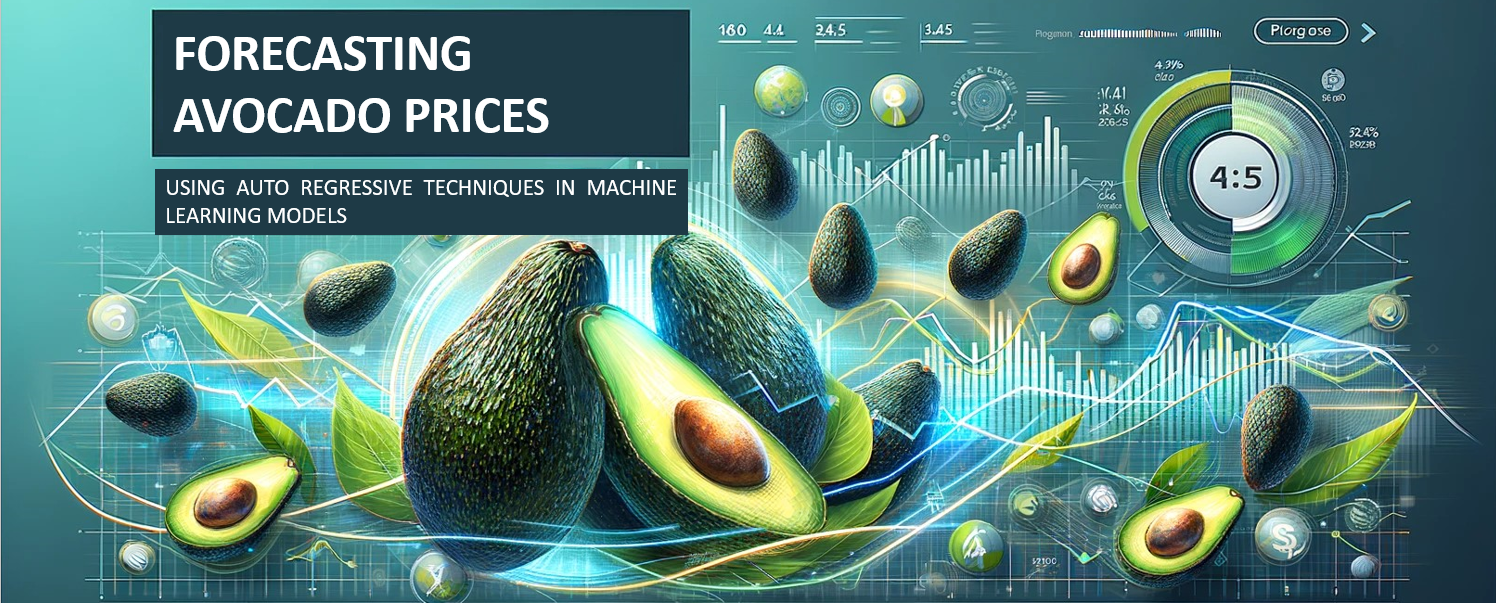

In [1]:
Image(filename='banner1.png')

<a id='Header2'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">SUMMARY</h1><a id='ExecSum'></a><a id='Title'></a><a

This technical report evaluates the benefit of autoregressive techniques in forecasting time series data. To do this, a time series dataset of avocado prices was used. Custom functions were built to simulate a scenario where a forecast for the period 5-weeks from the current is made on a rolling basis. 

This time series dataset was proven to be non-stationary and autocorrelated, which required autoregressive techniques to effectively build a forecasting system. Consequently, feature engineering was done through methods such as differencing by different time periods and extracting categorical variables from the months to capture possible seasonality. Additionally, there was extensive use of `ForecasterAutoReg` which enabled the utilization of lags in the machine learning models covered in ML1; Linear Regression, Lasso, Ridge, SVM, Random Forest, and Gradient Boosting Machine. Feature engineering was done to produce differenced data, as well as creating dummy variables for each of the months in order to capture possible seasonality. 

Additionally, backtesting with refitting was implemented through the custom functions. This meant that at each period, the training dataset grew to incorporate new historical data. This enabled the ML models to be refit at each period and adjust to new changes, within the limitations of the five week delay.

The optimal model was determined using hyperparameter tuning for the lowest MSE. MSE was used as the accuracy metric due to the fact that R-squared is not appropriate for non-stationary and autoregressive data. It was found that Ridge with an alpha of 0.1 performed best at minimizing MSE. This was evaluated against a naive approach, which is to simply assume that the price in five weeks is the current price. When compared to the naive approach, the MSE was 60% lower.


<a id='Header2'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">INTRODUCTION</h1><a id='ExecSum'></a><a id='Title'></a><a

In the Philippine dessert market, Avocadoria stands out with its unique avocado-based treats. For Purchasing Managers, their role is crucial in securing avocados, Avocadoria's key inventory. Fluctuating avocado prices directly impact profits, margins, and operations. This volatility underscores the need for an effective strategy to anticipate and manage these uncertainties.

Currently, Avocadoria relies on a simplistic approach to forecast avocado prices, where the future price, particularly for a period five weeks ahead, is assumed to be the same as the current spot price. This method, while straightforward, fails to account for the complex dynamics influencing avocado prices, such as seasonal variations, supply chain disruptions, and market demand shifts. As a result, this naive approach often leads to suboptimal purchasing decisions, either resulting in overstocking at high prices or understocking during periods of price dips. This also creates uncertainty in financial forecasting which hampers expansion and growth. 

Recognizing these challenges, the objective of this technical report is to explore and implement advanced machine learning models to enhance forecasting accuracy. Machine learning offers a robust framework to analyze historical price data, providing a more dynamic and informed prediction of future prices. By integrating these models into the purchasing strategy, Avocadoria aims to achieve a more stable inventory management system, mitigate the risks associated with price volatility, and ultimately, sustain its commitment to delivering high-quality, affordable desserts to customers. The transition to a data-driven forecasting approach is not just a strategic move for Avocadoria; it is a necessary step towards maintaining our competitive edge and financial stability in the ever-evolving food industry landscape.

<a id='Header2'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">PROJECT OBJECTIVES</h1><a id='ExecSum'></a><a id='Title'></a><a

This initiative is driven by the need to optimize Avocadoria's purchasing strategy, ensuring cost-effectiveness and inventory stability. The output of this technical report is to establish a more reliable and efficient forecasting system for avocado prices five-weeks ahead, leveraging the capabilities of machine learning models. The performance of the best machine learning model will be compared against the current naive forecasting approach based on the degree of MSE reduced for the 80 week test period. 

The learning objective of this technical report is to implement methods for handling time-series data that is non-stationary. This will require transforming data using differencing, implementing lags in the model through `ForecasterAutoreg`, and hyperparameter tuning through the use of custom functions to create a type of grid search. This will enable step-wise forecasting with a 5-week delay, model refitting at each forecasted window, and a non-fixed train size. 

The project will make use of regression and decision-tree models, namely; Linear Regression, Ridge, Lasso, SVM, Random Forest Regressor, and GBM. KNN was not deployed as this model is best used for interpolation rather than forecasting. Additionally, ARIMA, while powerful and appropriate for time-series data, was not deployed as scope was focused on improving existing models rather than introducing new ones.  

<a id='Header2'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">METHODOLOGY</h1><a id='ExecSum'></a><a id='Title'></a><a

The project begins with loading and pre-processing a dataset provided by the Haas Avocado Board and made available on Kaggle.com. This is real-world data based on the United States market. 

An Augmented Dickey-Fuller test is then deployed to establish context that the time series data is non-stationary, which is the core challenge of the project. Feature engineering will then be conducted to create new features out of the original time series. Basic exploratory data analysis will follow and this will provide visual context of the nature of the data.

For modeling, the steps will be first to segregate the data to train and test data, establishing the search space for hyperparameter tuning, and implementing grid search to find the optimal ML model. The report will then conclude with an evaluation of the model against the current naive approach implemented by Avocadoria, and provide recommendations on how to further improve it. 

<center><b>Table 1. </b> Project Pipeline</center>

||<center>Step</center>|<center>Detailed Description</center>| 
|:---|:---|:---|
|`1`|Data Pre-Processing| Data will be loaded from a CSV file provided by the Haaas Avocado Board and made available on Kaggle.com. The output of this step is a cleaned dataframe containing Average Weekly Price of avocados by date. 
|`2`|Augmented Dickey-Fuller Test| The ADF test will establish whether or not the time series data is non-stationary, which would establish the need for differencing and autoregressive techniques. |
|`3`|Feature Engineering| This will create new features out of the original time series by extracting the year to an individual feature, extracting the as individual dummy variables month via one-hot encoding, and creating features of price differences: AveragePrice<sub>t-1</sub> - AveragePrice<sub>t-n</sub>|
|`4`|Exploratory Data Analysis| The trend of the average price over time will be visualized, as well as histograms of the average weekly price and change in average weekly price.|
|`5`|Modeling| This involves several steps: data segregation, hyperparameter search space, metric selection for measuring accuracy, and finally, the model selection.|
|`6`|Evaluation| Evaluating the best ML model against the current naive forecasting approach and comparing the reduction in MSE.
|`7`|Conclusion| Conclusionary remarks given the results of the evaluation.|
|`8`|Recommendations| Suggested next steps to further improve accuracy and add more business value to Avacodoria.|

The project pipeline offers a thorough overview of the team's approach to the entire project, spanning from data retrieval to recommending additional studies. It furnishes an in-depth explanation of each step, encompassing sub-steps within each to ensure a comprehensive understanding of the workflow (Refer to Table 1).

<a id='Header2'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">DATA COLLECTION</h1><a id='ExecSum'></a><a id='Title'></a><a

<h2 style="color: navy;">A. DATA SOURCE</h2>

The project will utilize a real dataset from the Haas Avocado Board which was accessed from Kaggle through the following link: `kaggle.com/datasets/neuromusic/avocado-prices`. The dataset contains 3 years of information from 2015 to 2018.  

As described by HAB: The table represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

<h2 style="color: navy;">B. METADATA / DATA DESCRIPTION</h2>

The table below contains detailed descriptions of the data set used in this project. Prior to pre-processing techniques, it features 29 columns and 2,240 rows. Each row represents a customer that has transacted with the fictional U.S. grocery store (Refer to Table 2).

<html>
    <center><b>Table 2. </b> Dataset Metadata</center>

<center><table>
  <tr>
    <th>Feature Name</th>
    <th>Feature Description</th>
    <th>Retained?</th>
    <th>Data Type</th>  
  </tr>
  <tr>
    <td>Date</td>
    <td>The date of the observation</td>
    <td>Yes</td>
    <td>datetime64</td>
  </tr>
  <tr>
    <td>Average Price</td>
    <td>The average weekly price of a single avocado in U.S. dollars</td>
    <td>Yes</td>
    <td>float64
    </td>
  </tr>
  <tr>
    <td>type</td>
    <td>Conventional or organic</td>
    <td>Yes, for subsetting</td>
    <td>str</td>
  </tr>
  <tr>
    <td>year</td>
    <td>Year of observation</td>
    <td>Yes</td>
    <td>int64</td>
  </tr>
  <tr>
    <td>Region</td>
    <td>The city or region of the observation</td>
    <td>Yes, for subsetting</td>
    <td>str</td>
  </tr>
  <tr>
    <td>Total Volume</td>
    <td>Total number of avocados sold</td>
    <td>No</td>
    <td>int64</td>
  </tr>
  <tr>
    <td>4046</td>
    <td>Total number of avocados with PLU 4046 sold</td>
    <td>No</td>
    <td>int64</td>
  </tr>
  <tr>
    <td>4225</td>
    <td>Total number of avocados with PLU 4046 sold</td>
    <td>No</td>
    <td>int64</td>
  </tr>
  <tr>
    <td>4770</td>
    <td>Total number of avocados with PLU 4046 sold</td>
    <td>No</td>
    <td>int64</td>
  </tr>
</table></center>

<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">DATA PRE-PROCESSING</h1><a id='ExecSum'></a><a id='Title'></a><a

The below reads the data and filters for the average price for the Total US and for conventional avacados only (as opposed to organic). Volume data was not included in this technical report. Although this would have improved accuracy, the objective of the report was on isolating the benefit of autoregressive techniques. This focuses the project to a purely time series problem. 

In [3]:
df0 = pd.read_csv(data_dir)

df0 = df0.loc[(df0.region=='TotalUS') & (df0.type=='conventional')]
df0 = df0[['Date', 'AveragePrice']]
df0['Date'] = pd.to_datetime(df0['Date'])
df0.sort_values(by='Date', inplace=True)
df0 = df0.reset_index(drop=True)

In [4]:
df0.dropna(inplace=True)
df0.reset_index(drop=True, inplace=True)
df0.head(5)

,Date,AveragePrice
0,2015-01-04,0.95
1,2015-01-11,1.01
2,2015-01-18,1.03
3,2015-01-25,1.04
4,2015-02-01,0.89


<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">AUGMENTED DICKEY-FULLER TEST</h1><a id='ExecSum'></a><a id='Title'></a><a

Regression analysis, especially when applied to time series data, often assumes stationarity. Stationarity in a time series means that its statistical properties, such as mean, variance, and autocorrelation, are constant over time. This assumption is important for model interpretation, statistical significance, and forecasting accuracy. To test whether the time-series is stationary, an Augmented Dickey-Fuller test is applied using a significance level of 0.05. The hypotheses are as follows:

$H_0:$ The time series has a unit root, indicating it is non-stationary. \
$H_a:$ The time series does not have a unit root, suggesting it is stationary.

In [5]:
ts_data = df0.set_index('Date')['AveragePrice']

result = adfuller(ts_data)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.573341
p-value: 0.098633
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


The above ADF test returns an ADF statistic larger than the critical values, indicating that the null hypothesis cannot be rejected. The null hypothesis is that the time-series has non-stationarity and exhibits a time-dependent structure.

This presents a problem for regression analysis but this can be addressed using differencing and lags.

<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">FEATURE ENGINEERING</h1><a id='ExecSum'></a><a id='Title'></a><a

To prepare the data for the machine learning models, several features were created out of the existing features. This was done by:

* Differencing the current price with the previous n periods, which were then shifted forward by one unit in order to account for the fact that the change in price would not be known until the following period
* One-hot encoding on the month to capture possible seasonality, and dropping the first month
* Creating a date index 

In [6]:
# Create period differences columns
df1 = df0.copy()
for i in range(1,6):
    col_name = f'diff_t{i}'
    df1[col_name] = df1['AveragePrice'].diff(i)
    df1[col_name] = df1[col_name].shift(1) # deltas must be moved one period over
                                         # as this would not be information available at time of forecast


In [7]:
# Create the 'Year' and 'Month' columns
df2 = df1.copy()
df2['DateIndx'] = list(range(df2.shape[0]))
df2['Year'] = df2['Date'].dt.year
df2['Year'] = df2['Year'] - df2['Year'].min()
df2['Month'] = df2['Date'].dt.month
df2 = pd.get_dummies(df2, columns=['Month'], prefix='Month', drop_first=True)

df2.head(10)


,Date,AveragePrice,diff_t1,diff_t2,diff_t3,diff_t4,diff_t5,DateIndx,Year,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2015-01-04,0.95,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-11,1.01,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-18,1.03,0.06,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-25,1.04,0.02,0.08,NaN,NaN,NaN,3,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-02-01,0.89,0.01,0.03,0.09,NaN,NaN,4,0,1,0,0,0,0,0,0,0,0,0,0
5,2015-02-08,0.95,-0.15,-0.14,-0.12,-0.06,NaN,5,0,1,0,0,0,0,0,0,0,0,0,0
6,2015-02-15,1.03,0.06,-0.09,-0.08,-0.06,0.00,6,0,1,0,0,0,0,0,0,0,0,0,0
7,2015-02-22,1.02,0.08,0.14,-0.01,0.00,0.02,7,0,1,0,0,0,0,0,0,0,0,0,0
8,2015-03-01,0.97,-0.01,0.07,0.13,-0.02,-0.01,8,0,0,1,0,0,0,0,0,0,0,0,0
9,2015-03-08,1.02,-0.05,-0.06,0.02,0.08,-0.07,9,0,0,1,0,0,0,0,0,0,0,0,0


In [8]:
# Drop NAs and Reset indexes
df3 = df2.copy()
df3.dropna(inplace=True)
df3.reset_index(drop=True, inplace=True)
df3.head(2)

,Date,AveragePrice,diff_t1,diff_t2,diff_t3,diff_t4,diff_t5,DateIndx,Year,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,2015-02-15,1.03,0.06,-0.09,-0.08,-0.06,0.00,6,0,1,0,0,0,0,0,0,0,0,0,0
1,2015-02-22,1.02,0.08,0.14,-0.01,0.00,0.02,7,0,1,0,0,0,0,0,0,0,0,0,0


<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">EXPLORATORY DATA ANALYSIS</h1><a id='ExecSum'></a><a id='Title'></a><a

This section is reserved for preliminary investigations on the data set. It will focus on analyzing the distributions of features and targets that will be used further in statistical analysis.

<h2 style="color: navy;">A. DESCRIPTION</h2>

In [9]:
df = df3.copy()
df.describe().T[:6]

,count,mean,std,min,25%,50%,75%,max
AveragePrice,163.0,1.096196,0.175613,0.76,0.980,1.05,1.195,1.65
diff_t1,163.0,0.000982,0.066696,-0.22,-0.030,0.01,0.040,0.16
diff_t2,163.0,0.001288,0.093638,-0.29,-0.050,0.00,0.065,0.23
diff_t3,163.0,0.001534,0.113244,-0.39,-0.045,0.00,0.075,0.26
diff_t4,163.0,0.001840,0.133330,-0.46,-0.060,0.00,0.080,0.36
diff_t5,163.0,0.002638,0.148182,-0.50,-0.060,0.00,0.090,0.45


<h2 style="color: navy;">B. Price Trend</h2>

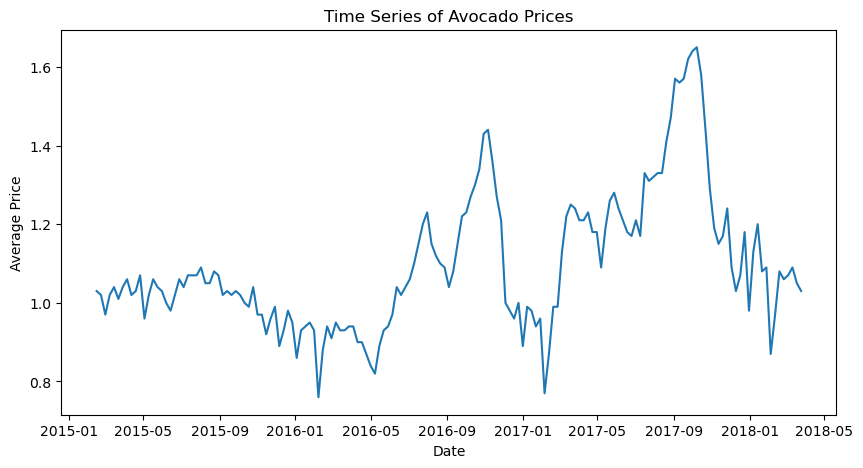

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['AveragePrice'])
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Time Series of Avocado Prices')
plt.show()

Even without the ADF test, it is clear that weekly price changes have an inconsistent degree of variance. It is also observable that October tends to lead to dramatic price increases in short periods of time. This will be a challenge for our forecasting system given that orders must be made 5 weeks in advance. 

<h2 style="color: navy;">C. AVERAGE PRICES</h2>

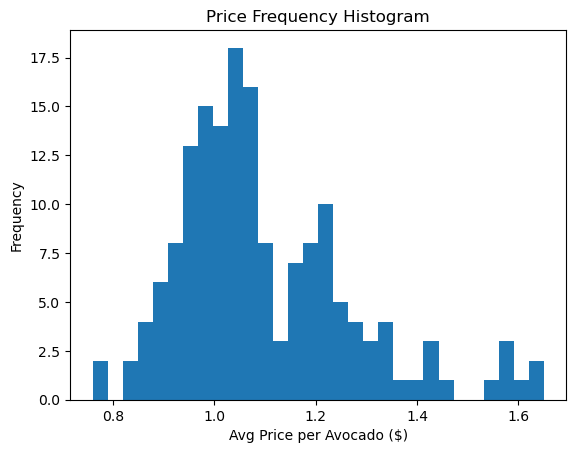

In [11]:
plt.hist(df['AveragePrice'], bins=30)
plt.xlabel('Avg Price per Avocado ($)')
plt.ylabel('Frequency')
plt.title('Price Frequency Histogram')
plt.show()

Prices of avacados appear to follow a right-skewed distribution that is also double-humped. However, given the non-stationarity of this time series data, this information is difficult to implement given the uncertain long-term mean. 

<h2 style="color: navy;">D. WEEKLY PRICE CHANGE</h2>

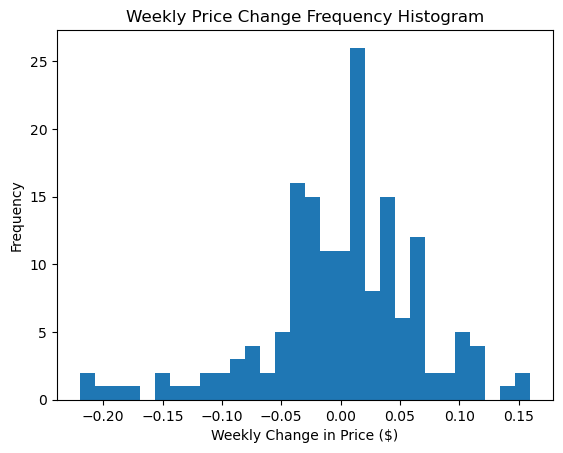

In [12]:
plt.hist(df['diff_t1'], bins=30)
plt.xlabel('Weekly Change in Price ($)')
plt.ylabel('Frequency')
plt.title('Weekly Price Change Frequency Histogram')
plt.show()

The above graph is a histogram of the first order weekly price differences. They appear normally distributed and somewhat left-skewed. Give that differences in the target are often stationary (this was also confirmed via ADF testing), this information can be useful for predicting the next period's price. 

<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">MODELING</h1><a id='ExecSum'></a><a id='Title'></a><a

<h3 style="color: navy;">A. DATA SEGREGATION</h3>
Splitting for the test and training dataset is often performed differently for time series forecasting than with other ML pipelines. Here, the splitting is not random but deliberately chosen. The initial training dataset contains the first half of the data set while the test dataset contains the latter half. This creates a setup for forecasting rather than interpolation.  

The forecaster makes one prediction at each period for the value five periods from now. As time moves forward and actual values become historical data, the training dataset expands. This is called an an **"expanding window"** approach.

At each period, the training model is backtested and refit to the new information that would be available up to that period. 


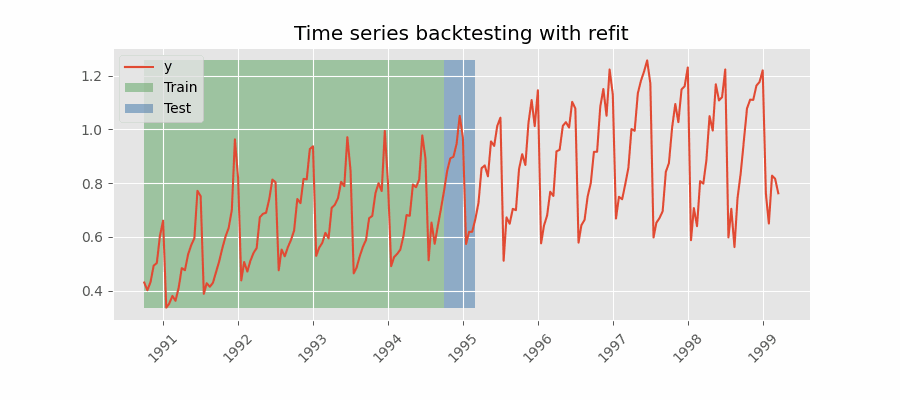

In [2]:
Image(filename="backtesting_refit.gif")

<h3 style="color: navy;">B. AUTOREGRESSION </h3>

Instead of directly fitting and transforming the data to the estimators, the estimators were first fed into `ForecasterAutoreg` which creates a ForecasterAutoreg object. This enables the use of lags to inform predictions, in addition to the already generated features. This means that previous actual Target values can be used to inform future predictions of the Target value. The lags here were set to a maximum of 5. This was done instead of setting up a lags grid which can be tuned in order to reduce processessing time.

<h3 style="color: navy;">C. HYPERPARAMETER SEARCH SPACE </h3>

In the custom forecaster_estimator functions above, looping was deployed to tune the parameters instead of `grid_search_forecaster`. This enabled testing of different tuning parameters, such as alpha, C, learning rate, max depth, and max features. The reason for not using a grid search such as grid_search_forecaster was because the forecasts are produced by predicting the next 5 steps in rolling batches, rather than predicting the value 5 steps from the current period, each period.

<h3 style="color: navy;">D. METRIC </h3>

The accuracy metric deployed was MSE. R-squared is not an appropriate test of accuracy for time series forecasts because it does not account for the temporal dependencies and autocorrelation present in time series data. Time series data points are often correlated with their past observations, and R-squared assumes that data points are independent, which leads to inaccurate assessments of predictive accuracy. Instead, MSE is more suitable for evaluating time series forecast accuracy.

The challenge with MSE is that it is difficult to interpret and depends on magnitude of the data. To address this, the degree of reduction relative to the naive forecasting approach is used to describe improvement.

<h3 style="color: navy;">E. MODEL SECTION </h3>


In [13]:
features =  ['diff_t1', 'diff_t2', 'diff_t3', 'diff_t4',
       'diff_t5', 'DateIndx', 'Year', 'Month_2', 'Month_3', 'Month_4',
       'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10',
       'Month_11', 'Month_12']

target_name = ['AveragePrice']

X = df[features]
y = df[target_name]

In [14]:
a, a1, a2 = forecaster_linearreg(X,y)
b, b1, b2 = forecaster_ridge(X,y)
c, c1, c2 = forecaster_lasso(X,y)
d, d1, d2 = forecaster_SVR(X,y)
e, e1, e2 = forecaster_RF(X,y)
f, f1, f2 = forecaster_GBM(X,y)

cols = ['Machine Learning Method', 'MSE', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df_results = pd.DataFrame(columns=cols)

df_results.loc[0] = a
df_results.loc[1] = b
df_results.loc[2] = c
df_results.loc[3] = d
df_results.loc[4] = e
df_results.loc[5] = f
df_results.sort_values(by='MSE', ascending=True)


,Machine Learning Method,MSE,Best Parameter,Top Predictor Variable,Run Time
1,Ridge,0.015703,alpha = 0.1,lag_1,5.809602
0,Linear Regression,0.016019,N/A,Year,1.155189
5,GBM,0.018985,"Learning Rate=0.1, Max Depth=3, Max Features=1",lag_2,977.174385
4,Random Forest,0.023615,"Max Depth=5, Max Features=0.2",lag_1,353.143130
2,Lasso,0.024115,alpha = 1e-05,lag_1,5.613920
3,SVR,0.048560,C=0.1,N/A,5.953804


<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">EVALUATION</h1><a id='ExecSum'></a><a id='Title'></a><a

The following conclusions can be made in the evaluation:

* Through the methods outlined in this report, an MSE approximately 59% lower than the naive method of forecasting was achieved. This was accomplished in spite of the 5-week delay of the forecast. 

* The optimal model was found to be Ridge with an alpha value of 0.1. An alpha value of 0.1 suggests a moderate level of regularization. This value is not too high to overly constrain the model, nor too low to be ineffective. It strikes a balance between maintaining the model's flexibility and controlling for overfitting.

* The top predictor was the first lag, which is the Average Price of 5-weeks prior. Its relative importance is about 0.23. The second most important predictor was the price between the last period and the period three weeks prior.  Lags 5 and 3 were also important, as well as the dummy variable for December. The dummy variable for December indicates seasonality in the average price.


Mean Absolute Percentage Error: 8.56%
Test error (MSE): 0.015702973958055148,


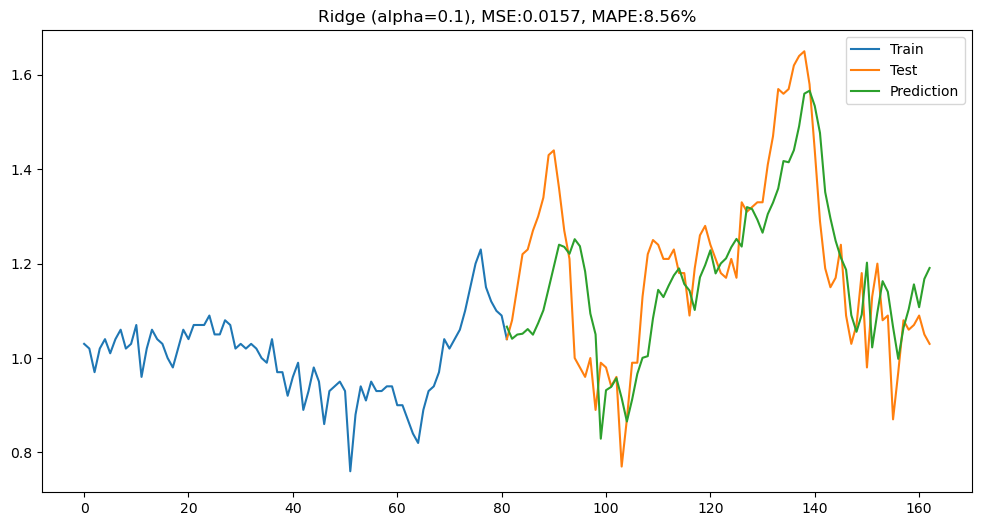

In [15]:
predictions = b1
y_test = y.loc[b1.index,'AveragePrice']
y_train = y.loc[:min(b1.index),'AveragePrice']
mse_score = mean_squared_error(
                y_true = y_test,
                y_pred = predictions.iloc[:]
            )
        
actual = np.array(y_test)
predicted = np.array(predictions)  

# Calculate MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) 

print(f'Mean Absolute Percentage Error: {mape*100:.2f}%')

print(f"Test error (MSE): {mse_score},")
text = f'Ridge (alpha=0.1), MSE:{mse_score}'

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f'Ridge (alpha=0.1), MSE:{mse_score:.4f}, MAPE:{mape*100:.2f}%')
y_train.plot(ax=ax, label='Train')
y_test.plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Prediction')
ax.legend();



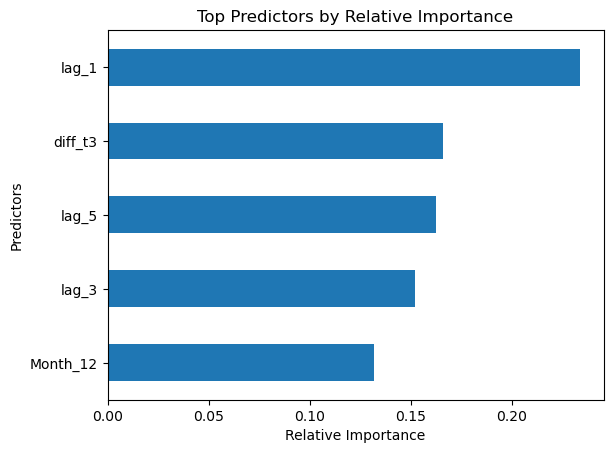

In [16]:
df_coefs = b2.set_index('feature')
df_coefs = df_coefs.abs().sort_values(by='importance', ascending=True)
#ser_coefs = df_coefs.iloc[:,0]
df_coefs.iloc[-5:,0].plot(kind='barh')
plt.xlabel('Relative Importance')
plt.ylabel('Predictors')
plt.title('Top Predictors by Relative Importance')
plt.show()

Test error (MSE): 0.03792317073170731


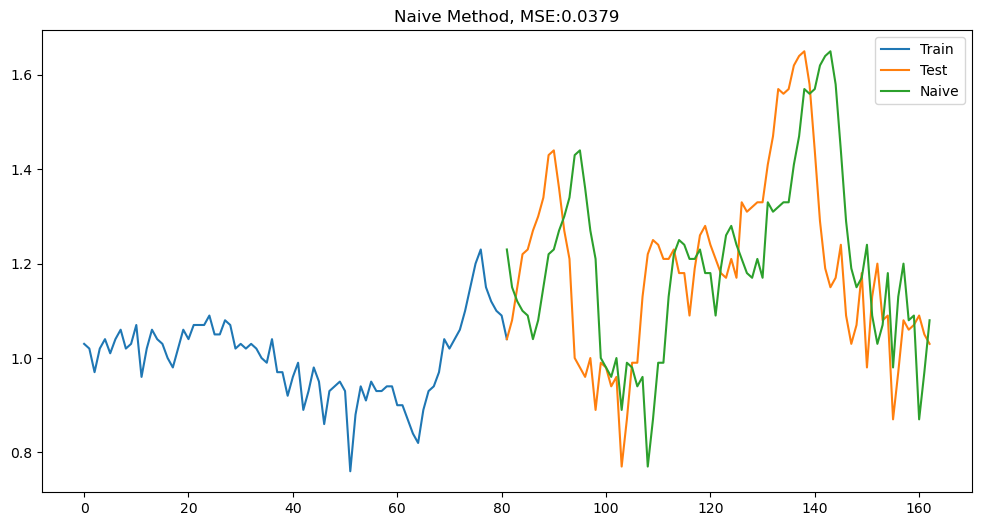

In [17]:
predictions = b1
y_naive = y.loc[predictions.index-5,'AveragePrice']
y_naive.index = b1.index
y_train = y.loc[:min(b1.index),'AveragePrice']
mse_score_naive = mean_squared_error(
                y_true = y_test,
                y_pred = y_naive.iloc[:]
            )
print(f"Test error (MSE): {mse_score_naive}")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(f'Naive Method, MSE:{mse_score_naive:.4f}')
y_train.plot(ax=ax, label='Train')
y_test.plot(ax=ax, label='Test')
y_naive.plot(ax=ax, label='Naive')
ax.legend();



<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">CONCLUSION</h1><a id='ExecSum'></a><a id='Title'></a><a

In this technical report, the use of autoregressive techniques for forecasting avocado prices have demonstrated significant value to Avocadoria, whose business operations and profitability are intrinsically tied to the availability and cost of avocados. The investigation revealed that the employment of specific methods such as utilizing lags, implementing an expanding window for training data, and applying differencing over various periods, significantly boosts the forecasting accuracy.

This enhanced accuracy in forecasting is a transformative tool for Avocadoria’s procurement strategy. With more precise predictions of avocado prices, the company can make informed decisions about when and how much inventory to purchase, leading to optimized spending, negotiations, reduced waste, and better management of price fluctuations. With greater certainty of its long term profits and margins, Avocadoria can better raise capital and plan for expansion.  

This approach enables Avocadoria to maintain a balance between supply and demand, ensuring cost-effectiveness and consistent availability of high-quality avocados for their products.

While the reduced MSE is large enough to provide value for Avocadoria, the acceptable accuracy of this methodology depends on the use case. With a mean average percentage error of 8.56%, this accuracy would not be enough for daytrading to speculate on the avocado futures.   

<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">RECOMMENDATION</h1><a id='ExecSum'></a><a id='Title'></a><a

In this technical report, we have meticulously analyzed the potential of autoregressive techniques for forecasting avocado prices, a critical endeavor for Avocadoria, whose business operations and profitability are intrinsically tied to the availability and cost of avocados. Our investigation revealed that the employment of specific methods such as utilizing lags, implementing an expanding window for training data, and applying differencing over various periods, significantly boosts the forecasting accuracy.

This enhanced accuracy in forecasting is not merely an academic achievement but a transformative tool for Avocadoria’s procurement strategy. With more precise predictions of avocado prices, the company can make informed decisions about when and how much inventory to purchase, leading to optimized spending, reduced waste, and better management of price fluctuations. This approach enables Avocadoria to maintain a balance between supply and demand, ensuring cost-effectiveness and consistent availability of high-quality avocados for their products.

Looking ahead, the potential for further refining our forecasting system is substantial. With more data collected, better estimates of the impact of monthly seasonal effects can be obtained to improve forecasts. 

Additionally, the integration of ARIMA (AutoRegressive Integrated Moving Average) models presents an exciting avenue for exploration. ARIMA's ability to handle different types of time series data and its flexibility in modeling a wider array of temporal structures could offer even more robust and accurate predictions.

Moreover, incorporating additional datasets into our analysis, such as avocado sales volumes and weather data, could provide deeper insights. Weather patterns have a profound impact on agricultural yields and, consequently, on prices. Similarly, understanding sales volumes can help in correlating market demand with price trends. This holistic approach could not only refine our price forecasting model but also offer Avocadoria a comprehensive view of the market dynamics.

In conclusion, the advancements in price forecasting methods outlined in this report hold the potential to revolutionize Avocadoria’s procurement strategy. By continuously evolving our analytical models and integrating diverse data sources, Avocadoria can look forward to not just navigating but also capitalizing on the complexities of the avocado market. This strategic foresight will be instrumental in sustaining Avocadoria's growth and success in the competitive landscape.

<a id='Header3'></a>
<h1 style="color:#ffffff; background-color:#001f3f; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;">REFERENCES</h1><a id='ExecSum'></a><a id='Title'></a><a

Haas Avocado Board. (n.d.). Avocado Prices. Kaggle. Retrieved November 25, 2023 from kaggle.com/datasets/neuromusic/
